In [1]:
import numpy as np 
import os
import sys
import trimesh  
import matplotlib.pyplot as plt 
import torch 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

# To allow me to import the functiosn from other folders from the parent directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from File_Paths.file_paths import interfaces_path, mesh_path 
from Functions.Point_Sampling.point_sampler import Point_Sampler

1. Add a tolerance so that the prohibited region points and the boundary points are not the same! 
2. Add a tolerance so that the prescribed thickness points and boundary points are not the same!

In [ ]:
from Test_Cases.Bridge_around_object.BRIDGE_Master_object import BRIDGE_Master_Object
BRIDGE = BRIDGE_Master_Object(Normalize=True)
domain = BRIDGE.domain
edge_vertices = BRIDGE.edge_vertices 
boundary_thickness = BRIDGE.boundary_thickness
obstacle_radius = BRIDGE.obstacle_radius
obstacle_thickness = BRIDGE.obstacle_thickness
obstacle_centroid = BRIDGE.obstacle_centroid 
BRIDGE.create_interfaces()

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


# Sample points
point_sampler = Point_Sampler(domain=domain, num_points_domain=50000) 
points = next(point_sampler)  # (N, 2)

# Get regions
points_on_dirichlet = BRIDGE.interfaces.sample_points_from_all_interfaces(num_points=1000,output_type='torch_tensor',device=device) 
points_on_thickness,idx_prohibited = BRIDGE.interfaces.is_inside_interface_thickness(points)  
prohibited,idx_prohibited = BRIDGE.interfaces.is_inside_prohibited_region(points) 

print(f"Number of points on Dirichlet: {points_on_dirichlet.shape[0]}")
print(f"Number of points inside thickness: {points_on_thickness.shape[0]}")
print(f"Number of points inside prohibited region: {prohibited.shape[0]}")


Number of points on Dirichlet: 1665
Number of points inside thickness: 7111
Number of points inside prohibited region: 10226


/Users/orjanjathun/Documents/TUM Classes/Masters Thesis/Code/Test_Cases/Bridge_around_object/boundary_surfaces.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=device)


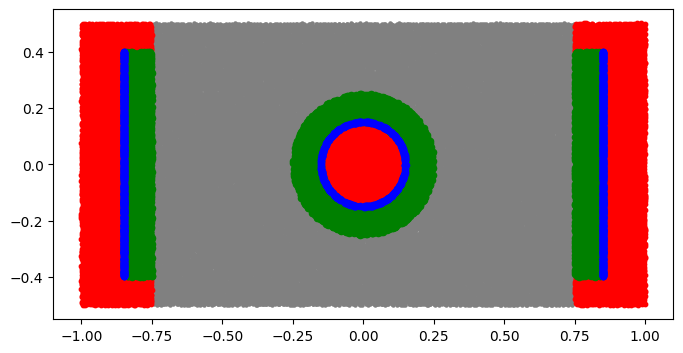

In [ ]:
if isinstance(points,torch.Tensor): 
    points = points.detach().cpu().numpy()   
if isinstance(points_on_thickness,torch.Tensor):
    points_on_thickness = points_on_thickness.detach().cpu().numpy()
if isinstance(points_on_dirichlet,torch.Tensor):
    points_on_dirichlet = points_on_dirichlet.detach().cpu().numpy()
if isinstance(prohibited,torch.Tensor):
    prohibited = prohibited.detach().cpu().numpy() 
plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], s=5, color='gray', label='Domain Points')
plt.scatter(prohibited[:, 0], prohibited[:, 1], s=10, color='red', label='Prohibited Points')
plt.scatter(points_on_thickness[:, 0], points_on_thickness[:, 1], s=20, color='green', label='Thickness Points')
plt.scatter(points_on_dirichlet[:, 0], points_on_dirichlet[:, 1], s=20, color='blue', label='Dirichlet Points') 


plt.gca().set_aspect('equal', adjustable='box') 

Need to Add: Normals, dirichlet multiplier, normalization, neumann load surfaces, plot for tensorboard etc

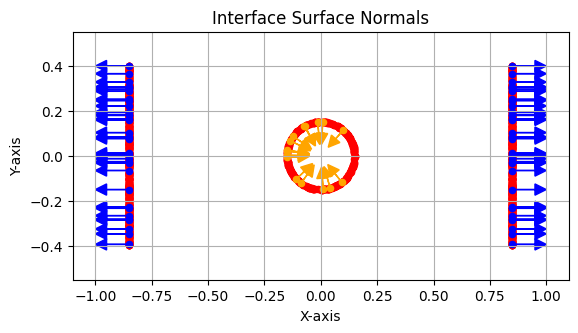

In [ ]:
Normals = BRIDGE.interfaces.get_all_prescribed_surface_normals(num_points=50,type='torch_tensor')
normals_points = Normals['points'].detach().cpu().numpy()  
dirichlet_points = normals_points[Normals['dirichlet_idx'].cpu()]
neumann_points = normals_points[Normals['neumann_idx'].cpu()]
dirichlet_normals = Normals['dirichlet_normals'].detach().cpu().numpy()
neumann_normals = Normals['neumann_normals'].detach().cpu().numpy() 

# Plotting the normals
plt.scatter(points[:, 0], points[:, 1], s=20, color='white', label='All Points')
plt.scatter(points_on_dirichlet[:, 0], points_on_dirichlet[:, 1], s=20, color='red', label='Dirichlet Points') 
for i in range(len(dirichlet_points)):
    plt.arrow(dirichlet_points[i, 0], dirichlet_points[i, 1], 
              dirichlet_normals[i, 0] * 0.1, dirichlet_normals[i, 1] * 0.1, 
              head_width=0.05, head_length=0.05, fc='blue', ec='blue')
for i in range(len(neumann_points)):
    plt.arrow(neumann_points[i, 0], neumann_points[i, 1], 
              neumann_normals[i, 0] * 0.05, neumann_normals[i, 1] * 0.05, 
              head_width=0.05, head_length=0.05, fc='orange', ec='orange')
plt.scatter(dirichlet_points[:, 0], dirichlet_points[:, 1], s=20, color='blue', label='Dirichlet Points')
plt.scatter(neumann_points[:, 0], neumann_points[:, 1], s=20, color='orange', label='Neumann Points')
plt.title('Interface Surface Normals')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect('equal', adjustable='box') 
plt.grid()
plt.show()


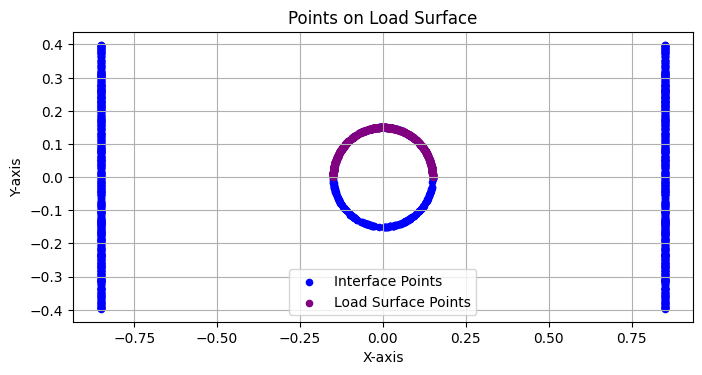

In [ ]:
points_on_load_surface = BRIDGE.interfaces.sample_points_on_neumann_boundary(num_points = 1000,  
                                                                            load_type = 'vertical',
                                                                            output_type = 'torch_tensor',
                                                                            ) 

# plots the points on the load surface
points_on_load_surface = points_on_load_surface.detach().cpu().numpy()  
plt.figure(figsize=(8, 8))
plt.scatter(points_on_dirichlet[:, 0], points_on_dirichlet[:, 1], s=20, color='blue', label='Interface Points')
plt.scatter(points_on_load_surface[:, 0], points_on_load_surface[:, 1], s=20, color='purple', label='Load Surface Points')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Points on Load Surface')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()
plt.legend()
plt.show() 

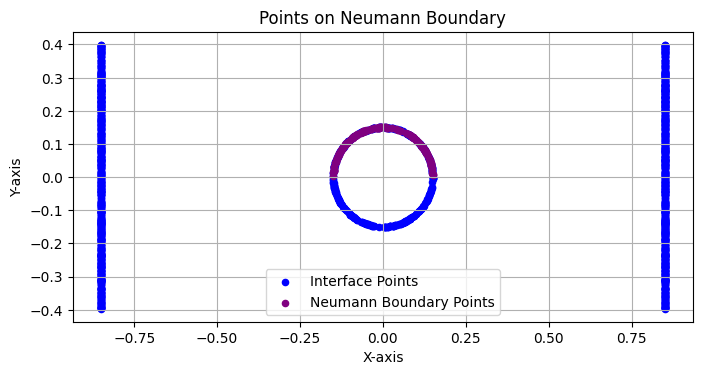

In [ ]:
pts = BRIDGE.interfaces.sample_points_from_all_interfaces(num_points=1000,output_type='torch_tensor',device=device) 
pts_neumann,idx_ne = BRIDGE.interfaces.is_on_neumann_boundary(pts, load_type='vertical') 

#plot the points on the neumann boundary
pts_neumann = pts_neumann.detach().cpu().numpy()  
plt.figure(figsize=(8, 8))
plt.scatter(points_on_dirichlet[:, 0], points_on_dirichlet[:, 1], s=20, color='blue', label='Interface Points')
plt.scatter(pts_neumann[:, 0], pts_neumann[:, 1], s=20, color='purple', label='Neumann Boundary Points')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Points on Neumann Boundary')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()
plt.legend()
plt.show()

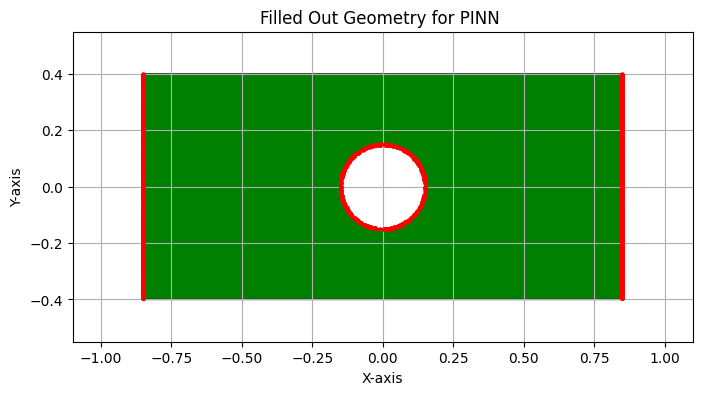

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.patches import Circle as mplCircle  #


radius = BRIDGE.obstacle_radius 
if isinstance(obstacle_centroid, torch.Tensor):
    x_centroid = BRIDGE.obstacle_centroid[0].item()
    y_centroid = obstacle_centroid[1].item() 
else:
    x_centroid = obstacle_centroid[0]
    y_centroid = obstacle_centroid[1]
if isinstance(BRIDGE.edge_vertices, torch.Tensor):
    x_min_left = BRIDGE.edge_vertices[0][0].item()
    x_max_right = BRIDGE.edge_vertices[2][0].item()
    y_min = BRIDGE.edge_vertices[0][1].item()
    y_max = BRIDGE.edge_vertices[1][1].item()
else:
    x_min_left = BRIDGE.edge_vertices[0][0]
    x_max_right = BRIDGE.edge_vertices[2][0]
    y_min = BRIDGE.edge_vertices[0][1]
    y_max = BRIDGE.edge_vertices[1][1]

Rectangle = torch.tensor([[x_min_left, y_min],
                     [x_min_left, y_max],
                     [x_max_right, y_max],
                     [x_max_right, y_min]],
                     device=device)

Circle = torch.tensor([x_centroid, y_centroid, radius], device=device, dtype=torch.float32) 
Rectangle_NP = Rectangle.detach().cpu().numpy()
Circle_NP = Circle.detach().cpu().numpy()

rect_verts = np.concatenate([Rectangle_NP, [Rectangle_NP[0]]])
rect_codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
theta = np.linspace(0, 2 * np.pi, 100)
circle_x = Circle_NP[0] + Circle_NP[2] * np.cos(theta)
circle_y = Circle_NP[1] + Circle_NP[2] * np.sin(theta)
circle_verts = np.column_stack((circle_x, circle_y))
circle_verts = np.concatenate([circle_verts, [circle_verts[0]]])
circle_codes = [Path.MOVETO] + [Path.LINETO]*(len(circle_verts) - 2) + [Path.CLOSEPOLY]
verts = np.concatenate([rect_verts, circle_verts])
codes = rect_codes + circle_codes
path = Path(verts, codes)

# Create patch 
polygon_with_hole = PathPatch(path, facecolor='green', edgecolor='black', label='Boundary Rectangle with Hole')

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
circle_outline = mplCircle((Circle[0], Circle[1]), Circle[2], color='r', fill=False, label='Obstacle Circle')
ax.add_artist(circle_outline)
ax.scatter(points[:, 0], points[:, 1], s=5, color='white', label='Domain Points', zorder=1) 
ax.scatter(points_on_dirichlet[:, 0], points_on_dirichlet[:, 1], s=5, color='red', label='Dirichlet Points', zorder=4)
ax.add_patch(polygon_with_hole)
ax.set_aspect('equal', adjustable='box')
plt.title('Filled Out Geometry for PINN ')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()
plt.show()

/var/folders/6q/hsnb05r97z70ylx7262m5fjm0000gn/T/ipykernel_17475/1210591708.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[0], colors='black', linewidths=1.5, linestyles='--', label='SDF = 0')


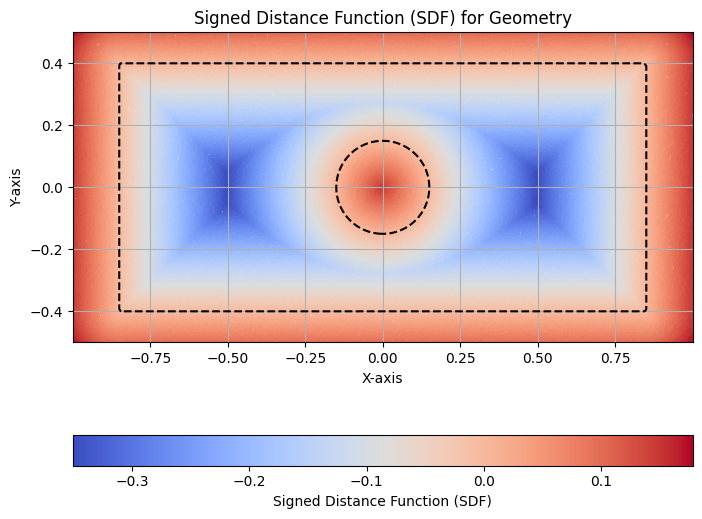

In [8]:
from scipy.interpolate import griddata

SDF = BRIDGE.interfaces.calculate_SDF(points)
SDF_NP = SDF.detach().cpu().numpy()
 
# Plotting the SDF
plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], c=SDF_NP, cmap='coolwarm', s=5, label='SDF Values')
plt.colorbar(label='Signed Distance Function (SDF)', orientation='horizontal')  

# Add SDF = 0 contour
x = points[:, 0]
y = points[:, 1]
xi = np.linspace(x.min(), x.max(), 500)
yi = np.linspace(y.min(), y.max(), 500)
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), SDF_NP.flatten(), (X, Y), method='linear')
plt.contour(X, Y, Z, levels=[0], colors='black', linewidths=1.5, linestyles='--', label='SDF = 0')

plt.title('Signed Distance Function (SDF) for Geometry')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

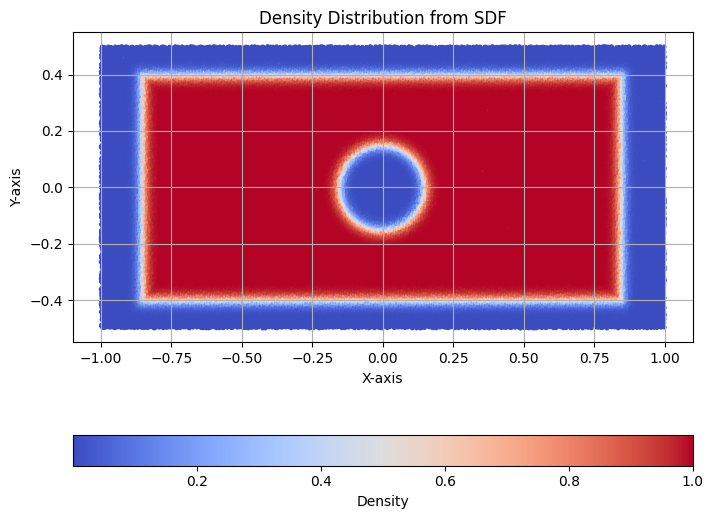

In [9]:
density = 1 / (1 + torch.exp(100 * SDF))

plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], c=density.detach().cpu().numpy(), cmap='coolwarm', s=5, label='Density Values')
plt.colorbar(label='Density', orientation='horizontal')
plt.title('Density Distribution from SDF')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

(49729, 2) (49729,)


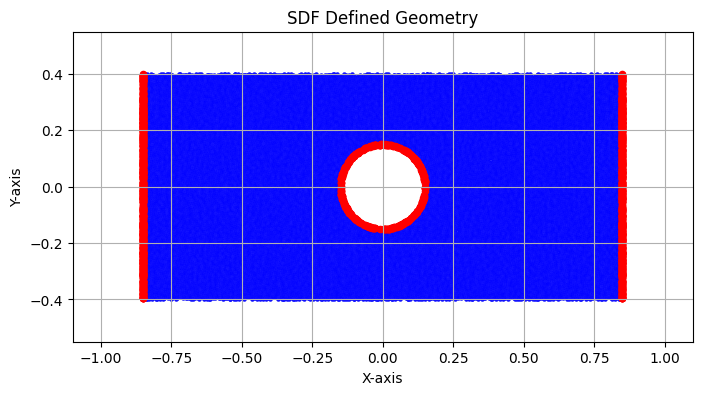

In [ ]:
if isinstance(points, torch.Tensor):
    points = points.detach().cpu().numpy()  
if isinstance(density, torch.Tensor):
    density = density.detach().cpu().numpy().flatten()  
print(points.shape, density.shape) 
points_density = points[density > 0.5]  
plt.figure(figsize=(8, 8))
plt.scatter(points_density[:, 0], points_density[:, 1], s=5, color='blue', label='High Density Points')
plt.scatter(points[:, 0], points[:, 1], s=5, color='white', alpha=0.01, label='All Points')
plt.scatter(points_on_dirichlet[:, 0], points_on_dirichlet[:, 1], s=20, color='red', label='Dirichlet Points') 
plt.title('SDF Defined Geometry')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

Dirichlet Multiplier Shape: tensor([0.0356, 0.0350, 0.0573,  ..., 0.0614, 0.0020, 0.0478])


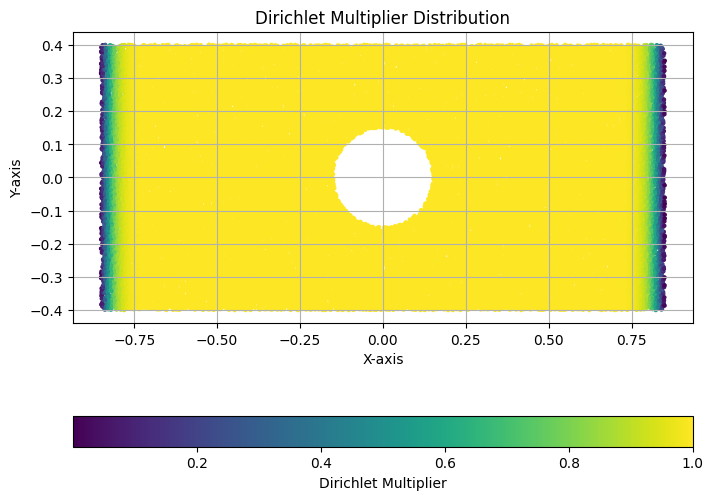

In [ ]:
dirichlet_multiplier = BRIDGE.enforce_dirichlet_boundary_conditions(points_density)

def enforce_dirichlet_BC(alpha,coords):
        
        edge_vertices = BRIDGE.edge_vertices

        device = coords.device if isinstance(coords, torch.Tensor) else None
        if isinstance(edge_vertices, torch.Tensor): 
            x_left  = edge_vertices[0, 0].item()
            x_right = edge_vertices[2, 0].item()  
        else:
            x_left  = edge_vertices[0, 0]
            x_right = edge_vertices[2, 0] 

        distances_left = torch.abs(coords[:, 0] - x_left)
        distances_right = torch.abs(coords[:, 0] - x_right)
        multiplier_left = torch.tanh(alpha*distances_left) 
        multiplier_right = torch.tanh(alpha*distances_right)  
        multiplier = multiplier_left * multiplier_right
        if device is not None:
                multiplier = multiplier.to(device)  
     
        #multiplier = torch.sin(np.pi * (x - x_min) / (x_max - x_min)) 

        return multiplier 

dirichlet_multiplier = enforce_dirichlet_BC(25,torch.from_numpy(points_density)) 

print("Dirichlet Multiplier Shape:", dirichlet_multiplier)  

plt.figure(figsize=(8, 8))
plt.scatter(points_density[:, 0], points_density[:, 1], c=dirichlet_multiplier.flatten(), cmap='viridis', s=5, label='Dirichlet Multiplier Values')
plt.colorbar(label='Dirichlet Multiplier', orientation='horizontal')
plt.title('Dirichlet Multiplier Distribution')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()